In [1]:
import pandas as pd

df = pd.read_parquet("active_labeled.parquet")
df

,filename,filepath,label
0,AnnualCrop_2216.tif,data/eurosat_rgb/0/AnnualCrop_2216.jpg,Annual Crop
1,AnnualCrop_1331.tif,data/eurosat_rgb/0/AnnualCrop_1331.jpg,Annual Crop
2,AnnualCrop_631.tif,data/eurosat_rgb/0/AnnualCrop_631.jpg,Annual Crop
3,AnnualCrop_2904.tif,data/eurosat_rgb/0/AnnualCrop_2904.jpg,Annual Crop
4,AnnualCrop_1963.tif,data/eurosat_rgb/0/AnnualCrop_1963.jpg,Annual Crop
...,...,...,...
1183,None,data/eurosat_rgb/5/Pasture_1939.jpg,Pasture
1184,None,data/eurosat_rgb/3/Highway_125.jpg,Highway
1185,None,data/eurosat_rgb/6/PermanentCrop_825.jpg,Permanent Crop
1186,None,data/eurosat_rgb/3/Highway_1319.jpg,Highway


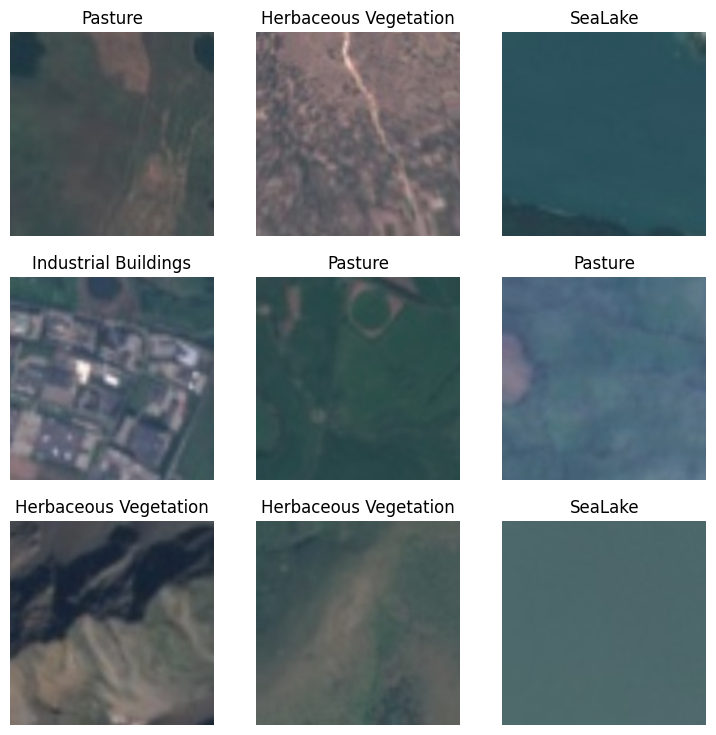

In [2]:
from fastai.vision.all import *

base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label",
    bs=16,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224),
)

dls.show_batch()

In [3]:
learn = vision_learner(dls, "vit_small_patch16_224", metrics=accuracy).to_fp16()
# learn.lr_find(suggest_funcs=(valley, slide))

/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,2.632453,1.040042,0.649789,00:03
1,1.619640,0.838944,0.721519,00:02
2,1.291600,0.898326,0.725738,00:03


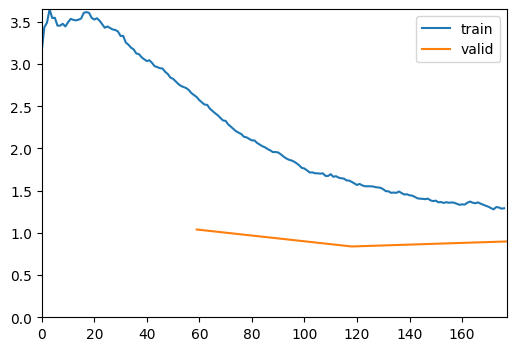

epoch,train_loss,valid_loss,accuracy,time
0,0.936929,0.708976,0.797468,00:03
1,0.750371,0.507807,0.856540,00:04
2,0.492533,0.461359,0.852321,00:05


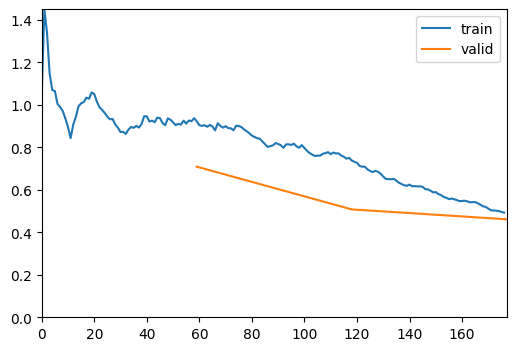

In [4]:
learn.fine_tune(3, base_lr=5e-3, freeze_epochs=3, cbs=ShowGraphCallback())


In [5]:
test_df = pd.read_parquet("data/eurosat_rgb/evaluation_samples.parquet")
test_df

,filename,filepath,label
0,AnnualCrop_1002.tif,data/eurosat_rgb/0/AnnualCrop_1002.jpg,Annual Crop
1,AnnualCrop_1003.tif,data/eurosat_rgb/0/AnnualCrop_1003.jpg,Annual Crop
2,AnnualCrop_1007.tif,data/eurosat_rgb/0/AnnualCrop_1007.jpg,Annual Crop
3,AnnualCrop_1012.tif,data/eurosat_rgb/0/AnnualCrop_1012.jpg,Annual Crop
4,AnnualCrop_1015.tif,data/eurosat_rgb/0/AnnualCrop_1015.jpg,Annual Crop
...,...,...,...
5395,SeaLake_975.tif,data/eurosat_rgb/9/SeaLake_975.jpg,SeaLake
5396,SeaLake_983.tif,data/eurosat_rgb/9/SeaLake_983.jpg,SeaLake
5397,SeaLake_989.tif,data/eurosat_rgb/9/SeaLake_989.jpg,SeaLake
5398,SeaLake_990.tif,data/eurosat_rgb/9/SeaLake_990.jpg,SeaLake


In [6]:
filepaths = test_df["filepath"].tolist()
labels = test_df["label"].tolist()
test_dl = dls.test_dl(filepaths, bs=16)
preds, _, cls_preds = learn.get_preds(dl=test_dl, with_decoded=True)

results = pd.DataFrame(
    {
        "filepath": filepaths,
        "label": labels,
        "pred_label": [learn.dls.vocab[i] for i in cls_preds.numpy()],
    }
)

accuracy = float((results["label"] == results["pred_label"]).mean())
accuracy


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


0.945925925925926